In [1]:
%load_ext autoreload
%load_ext tensorboard
%matplotlib inline

In [2]:
import matplotlib
import numpy as np
import os
import random
import yaml
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
from matplotlib import cm
import seaborn as sns
from importlib import reload
from pathlib import Path
import sklearn
import joblib
import torch
import pandas as pd
import copy

# Dataset Visualization

In [3]:
baseline_dataset_config = {
  "dataset": "color_mnist_add",
    "root_dir": "data/",
    "num_workers": 8,
    "batch_size": 2048,
    "num_operands": 5,
    "selected_digits": [3, 8],
    "count_labels": True,
    "low_noise_level": 1,
    "noise_level": 0.25,
    "test_low_noise_level": 1,
    "test_noise_level": 0.25,
    "train_dataset_size": 500,
    "test_dataset_size": 500,
    "sampling_percent": 1,
    "sampling_groups": True,
    "test_subsampling": 1,
    "weight_loss": False,
    "spurious_strength": 0.1,
    "color_by_label": False,
    "colors": ["random_1", "random_2", "random_3", "random_4", "random_5", "random_6", "random_7", "random_8", "random_9", "random_10"],
    "digit_color_distribution": {
      0: ["spurious", None, None, None, None, None, None, None, None, None],
      1: [None, "spurious", None, None, None, None, None, None, None, None],
      2: [None, None, "spurious", None, None, None, None, None, None, None],
      3: [None, None, None, "spurious", None, None, None, None, None, None],
      4: [None, None, None, None, "spurious", None, None, None, None, None],
      5: [None, None, None, None, None, "spurious", None, None, None, None],
      6: [None, None, None, None, None, None, "spurious", None, None, None],
      7: [None, None, None, None, None, None, None, "spurious", None, None],
      8: [None, None, None, None, None, None, None, None, "spurious", None],
      9: [None, None, None, None, None, None, None, None, None, "spurious"],
    },
    "test_digit_color_distribution": {
      0: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      1: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      2: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      3: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      4: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      5: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      6: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      7: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      8: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
      9: [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    },
}

downstream_spurious_dataset_config = copy.deepcopy(baseline_dataset_config)
downstream_spurious_dataset_config['spurious_strength'] = 0.95
downstream_spurious_dataset_config['color_by_label'] = True

concept_spurious_dataset_config = copy.deepcopy(baseline_dataset_config)
concept_spurious_dataset_config['spurious_strength'] = 0.95
concept_spurious_dataset_config['color_by_label'] = False

ood_dataset_config = copy.deepcopy(baseline_dataset_config)
ood_dataset_config['test_noise_level'] = 0.5

/home/me466/venv/lib/python3.8/site-packages/pytorch_lightning/utilities/seed.py:47: LightningDeprecationWarning: `pytorch_lightning.utilities.seed.seed_everything` has been deprecated in v1.8.0 and will be removed in v2.0.0. Please use `lightning_fabric.utilities.seed.seed_everything` instead.
  rank_zero_deprecation(
Global seed set to 42


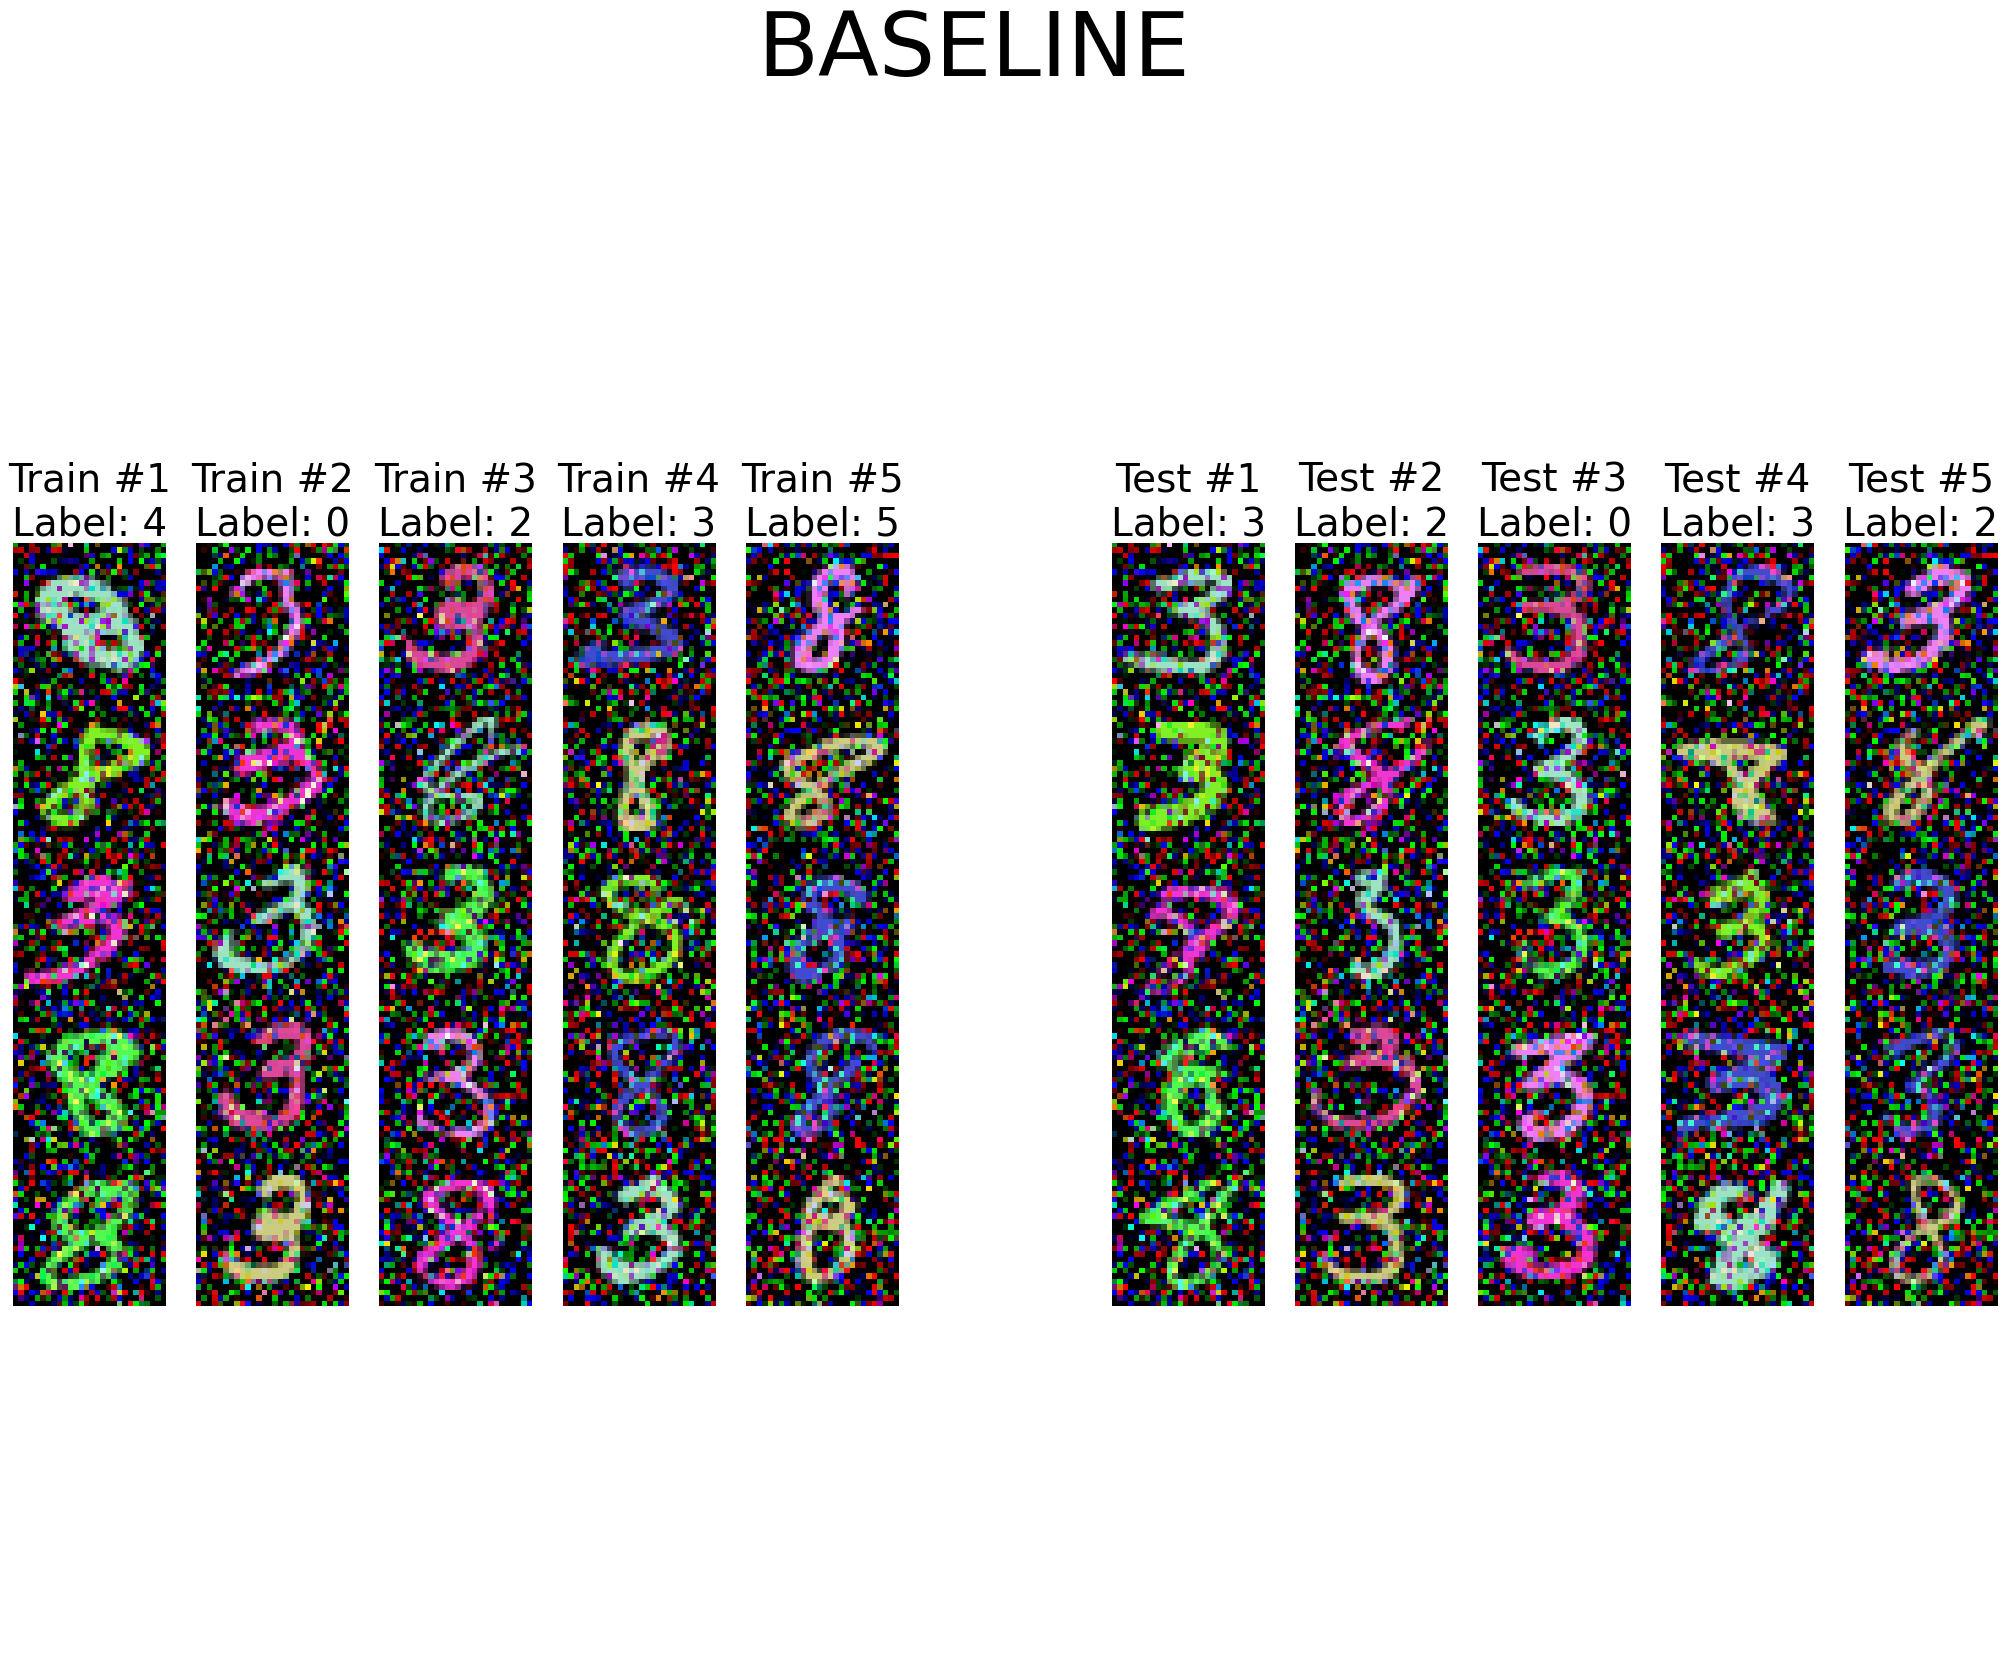

Global seed set to 42


--------------------------------------------------------------------------------


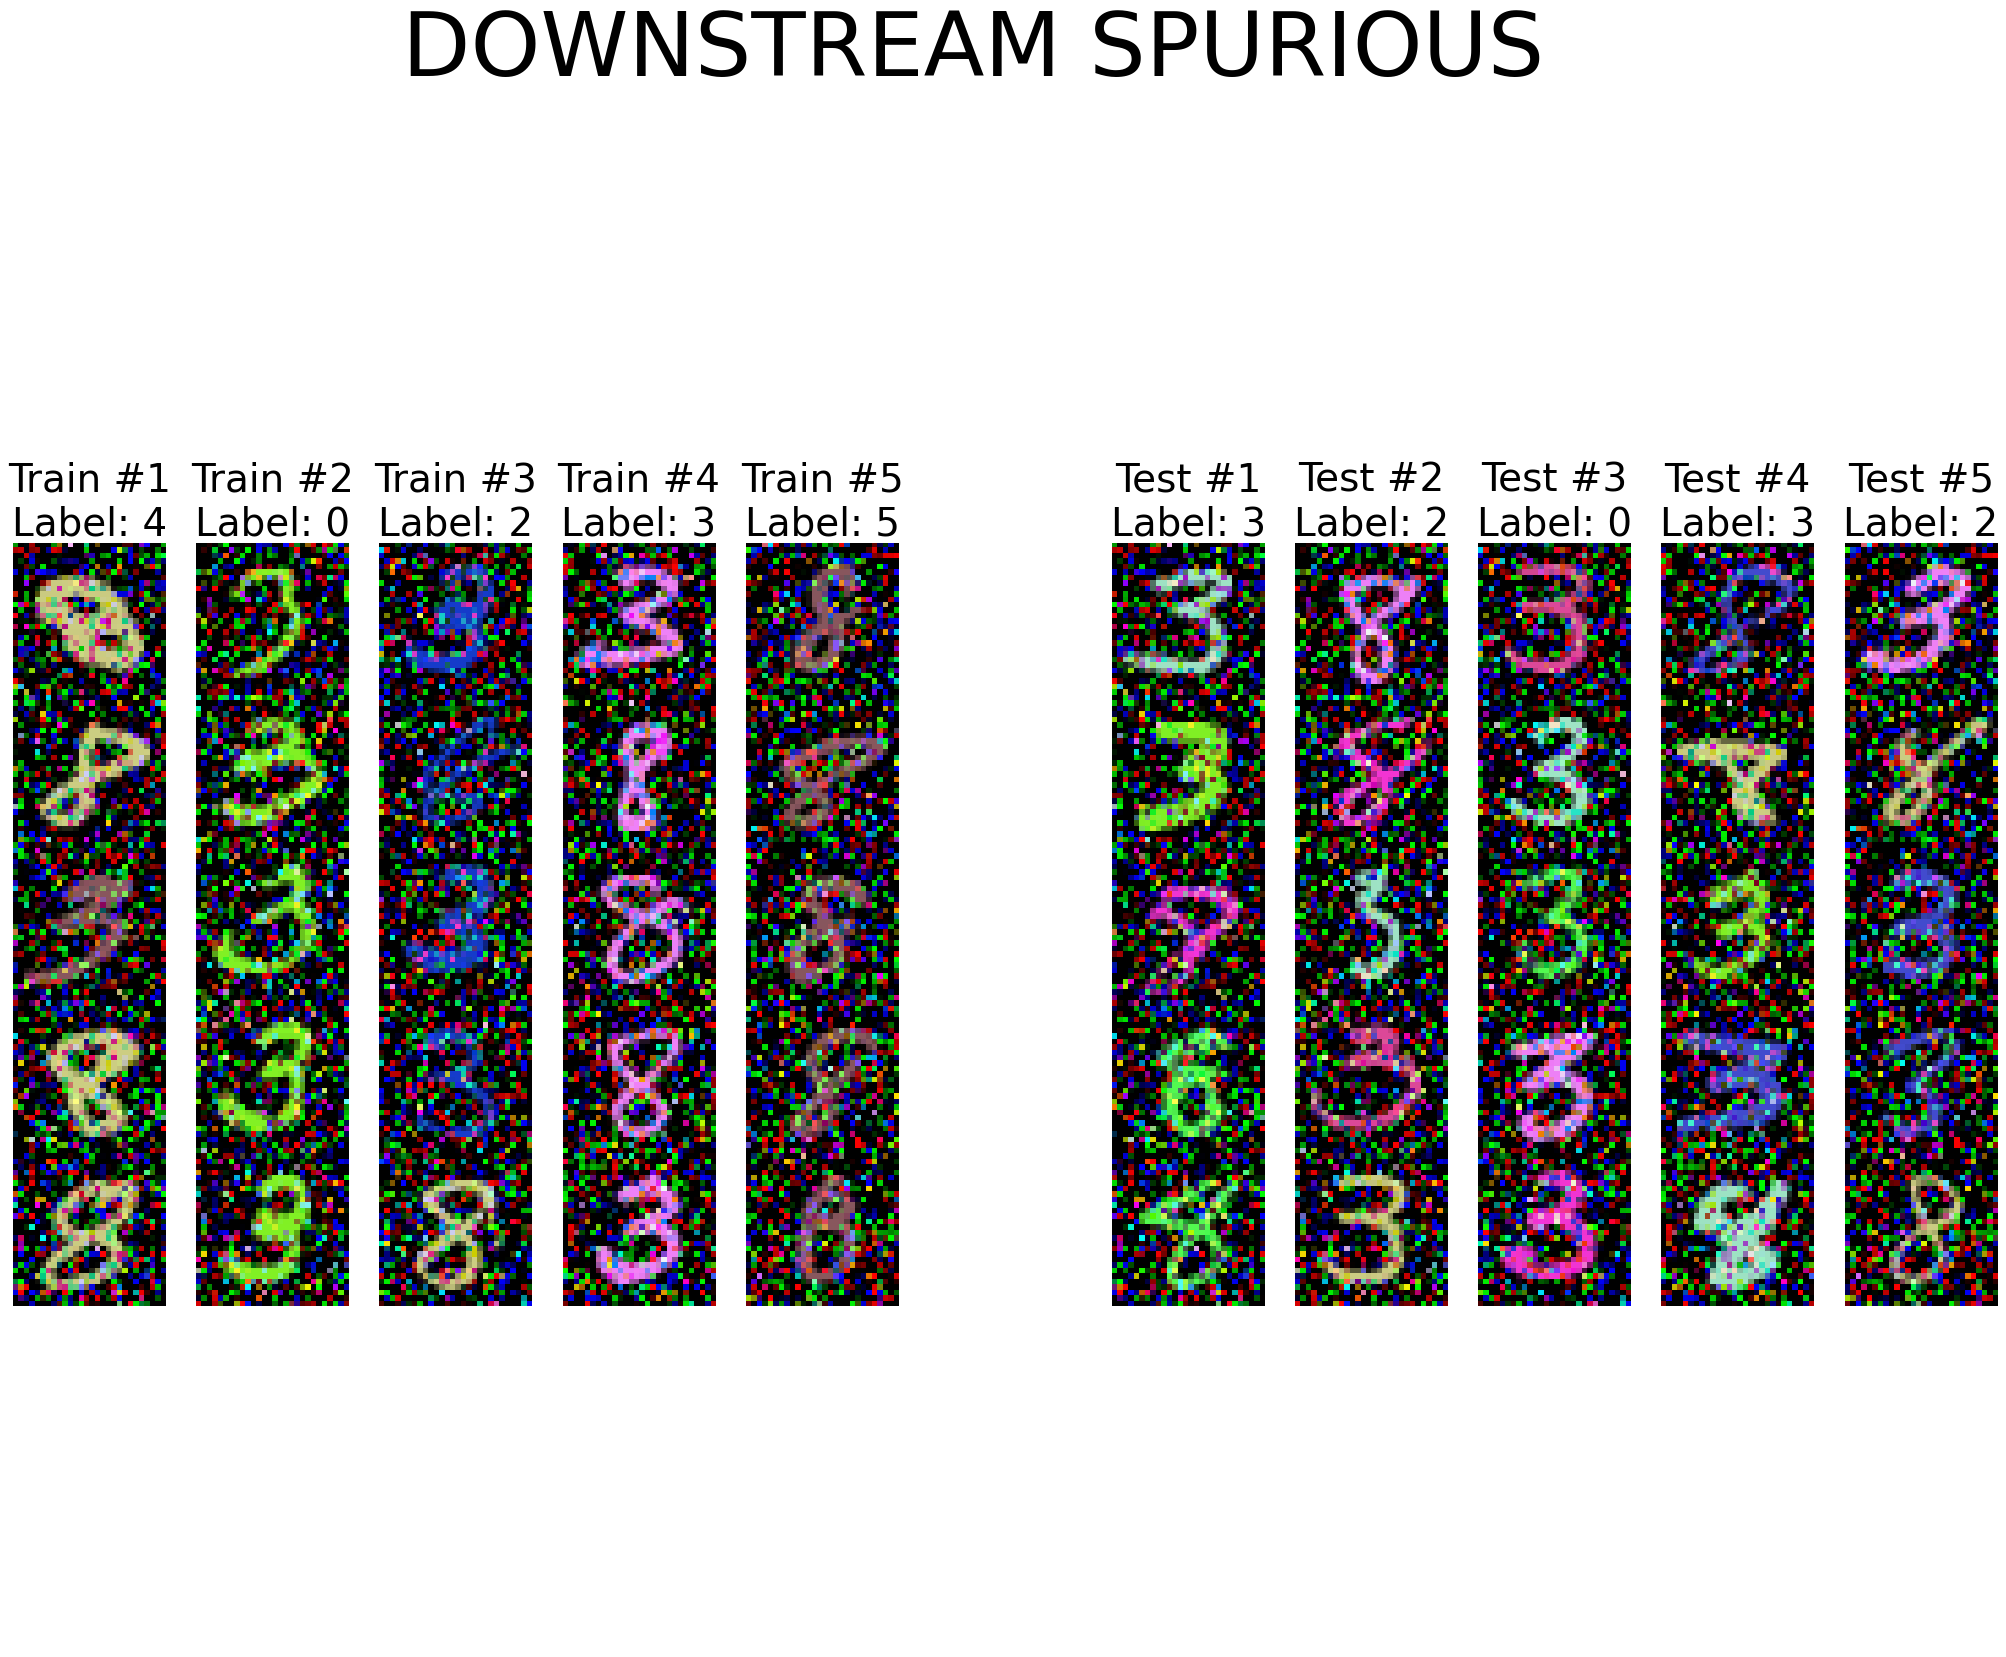

Global seed set to 42


--------------------------------------------------------------------------------


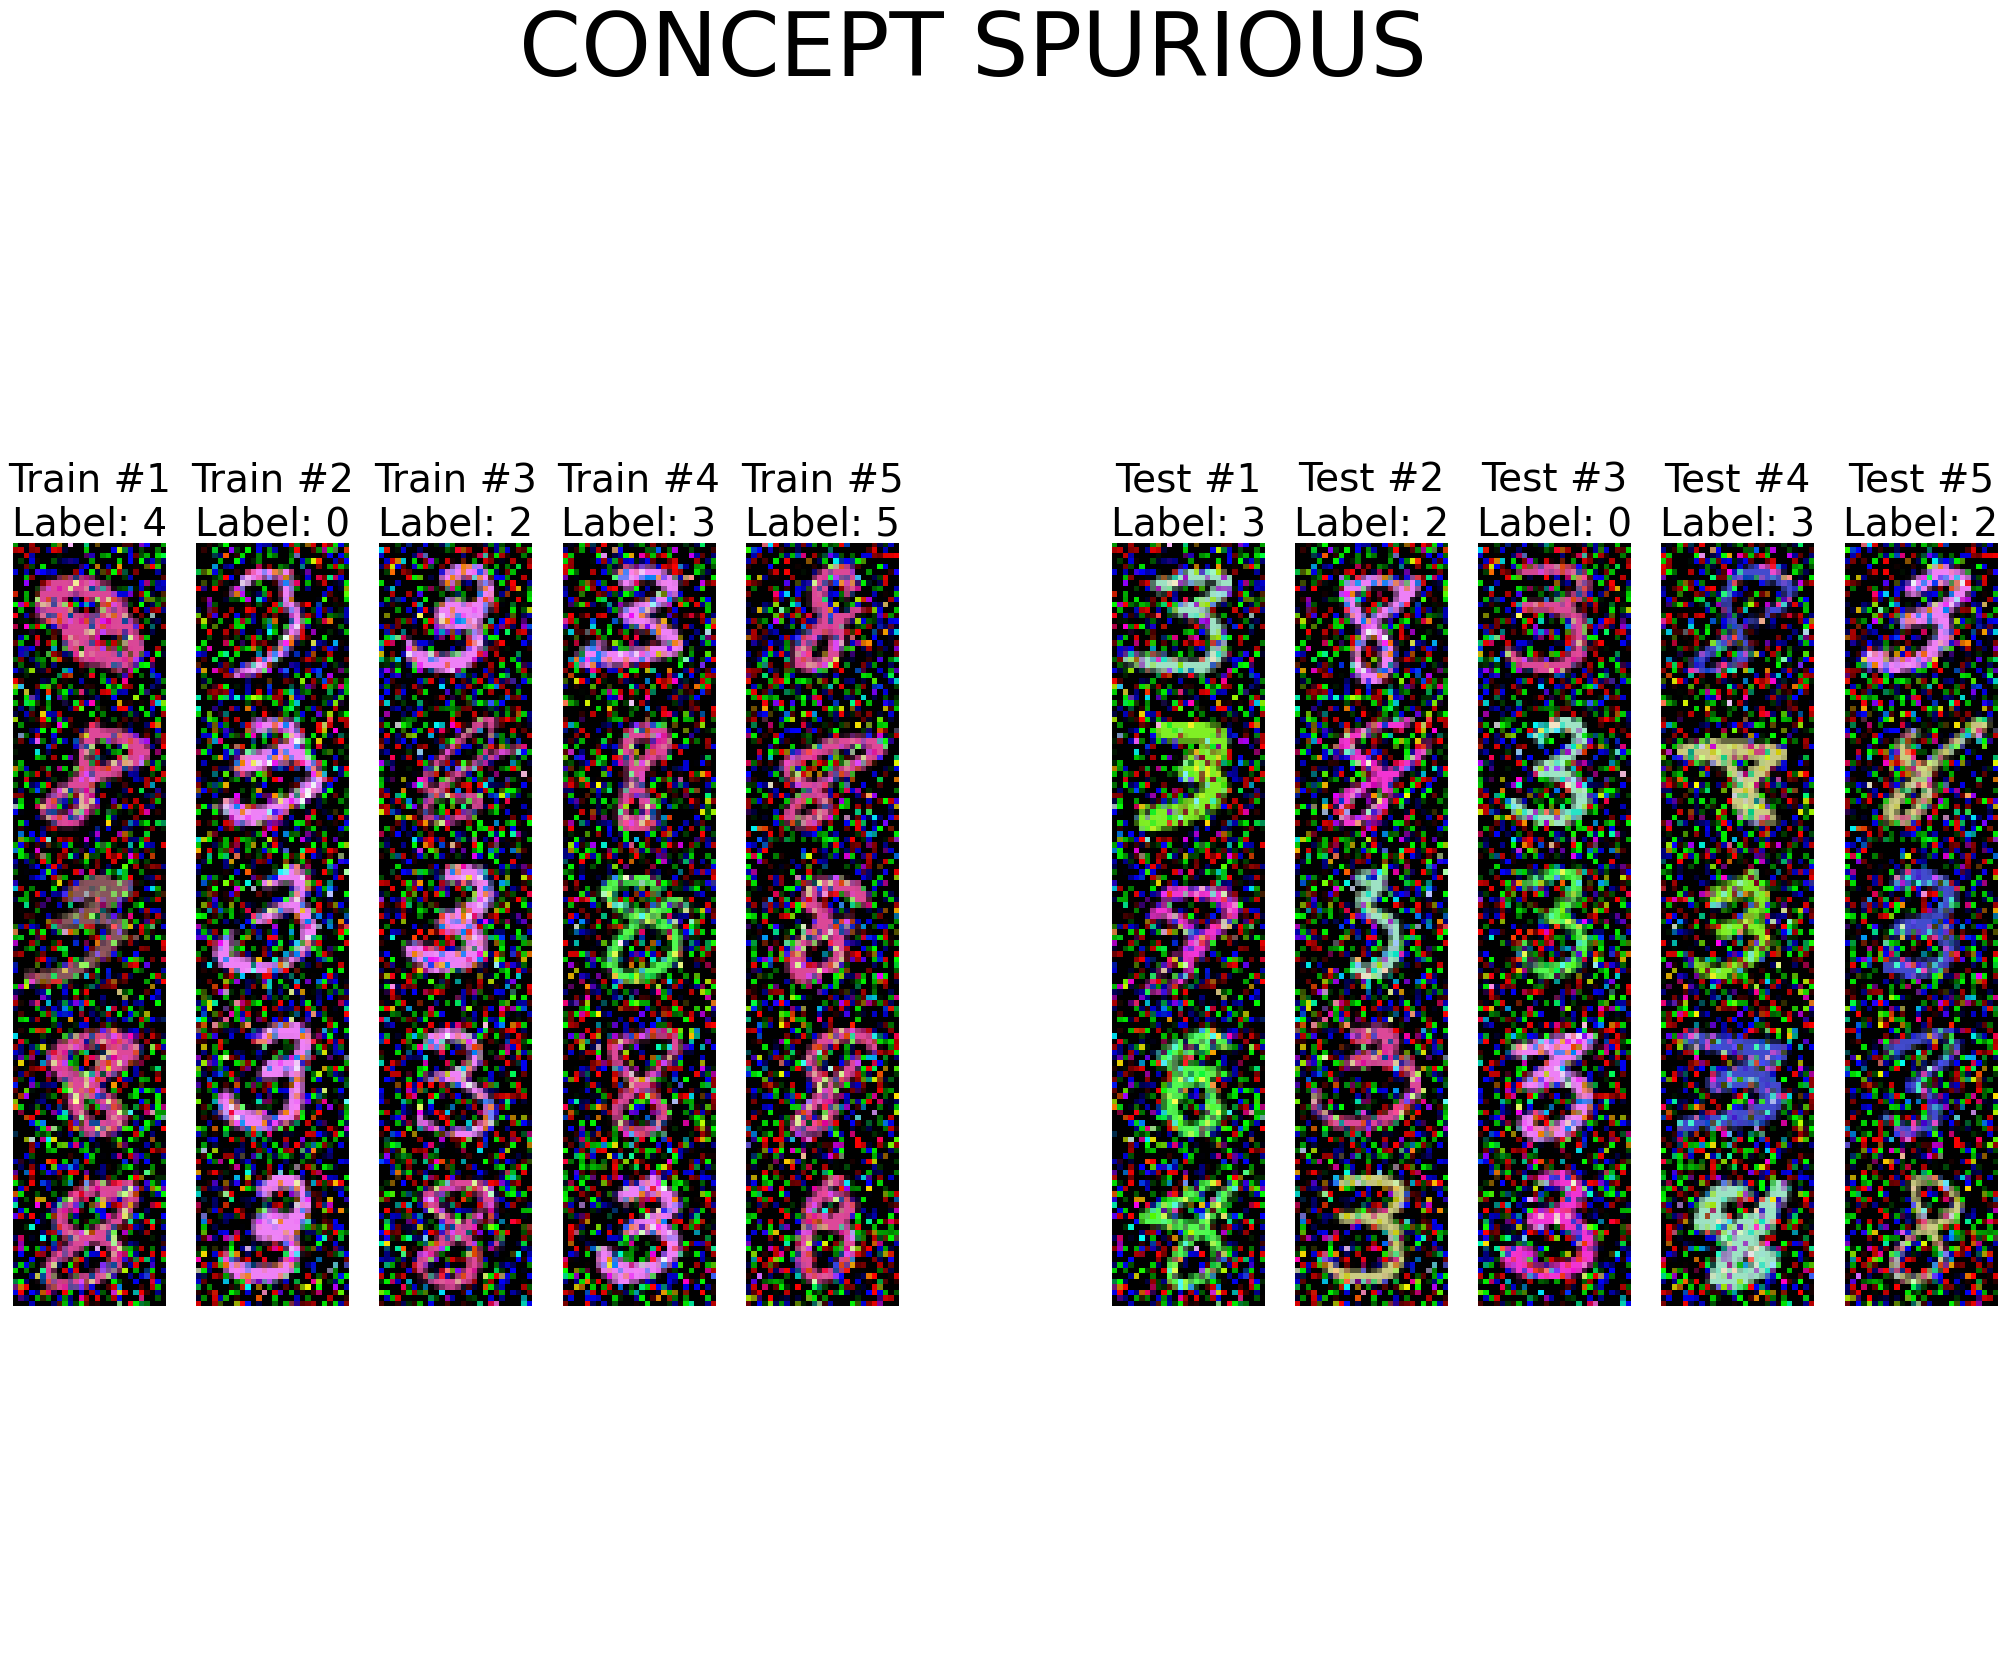

Global seed set to 42


--------------------------------------------------------------------------------


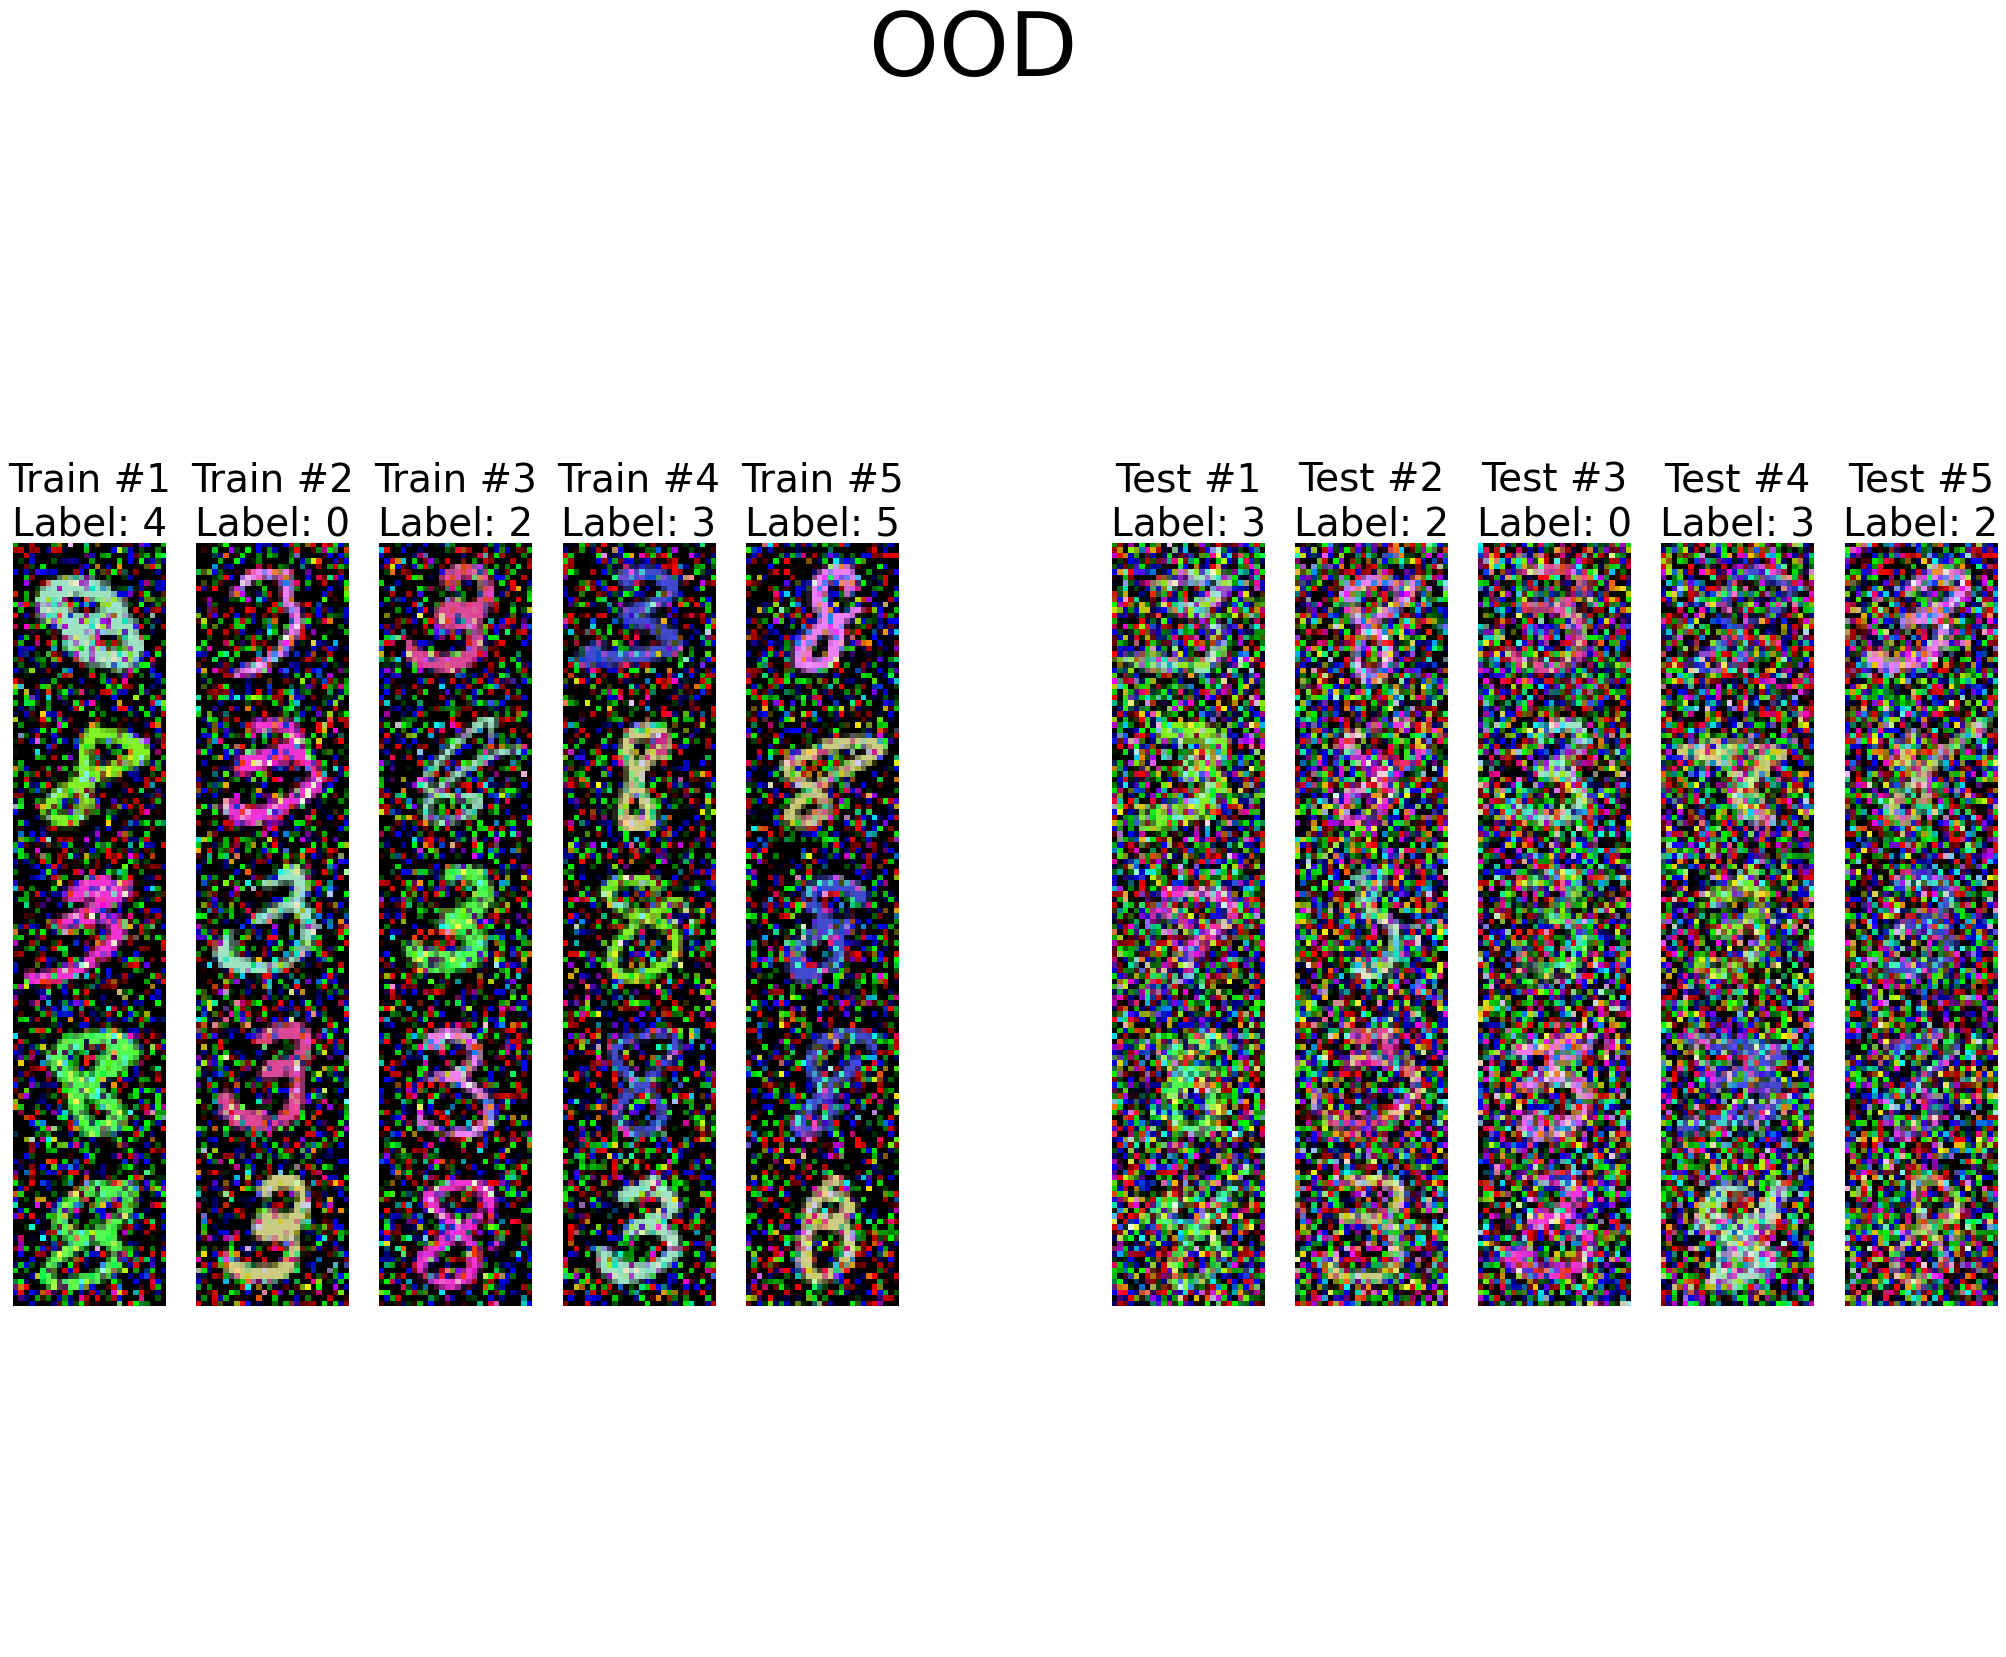

--------------------------------------------------------------------------------


In [4]:
import cem.utils.data as data_utils
import cem.data.color_mnist_add as color_mnist_data_module

n_samples = 5
for (dataset_config, name) in [
    (baseline_dataset_config, "baseline"),
    (downstream_spurious_dataset_config, "downstream spurious"),
    (concept_spurious_dataset_config, "concept spurious"),
    (ood_dataset_config, "OOD"),
]:
    train_dl, val_dl, test_dl, imbalance, (n_concepts, n_tasks, concept_map) = \
        color_mnist_data_module.generate_data(
            config=dataset_config,
            seed=42,
            output_dataset_vars=True,
            root_dir=dataset_config.get('root_dir', None),
        )
    x_train, y_train, c_train = data_utils.daloader_to_memory(train_dl)
    fig, axs = plt.subplots(1, 2*n_samples + 1, figsize=(32, 24), dpi=80)
    fig.suptitle(name.upper(), fontsize=80)
    for i in range(n_samples):
        axs[i].set_title(f"Train #{i+1}\nLabel: {y_train[i]}", fontsize=35)
        axs[i].imshow(x_train[i, :, :, :].transpose(1, 2, 0))
        axs[i].axis("off")
    x_test, y_test, c_test = data_utils.daloader_to_memory(test_dl)
    axs[n_samples].axis("off")
    for i in range(n_samples):
        axs[n_samples + 1 + i].set_title(f"Test #{i+1}\nLabel: {y_test[i]}", fontsize=35)
        axs[n_samples + 1 + i].imshow(x_test[i, :, :, :].transpose(1, 2, 0))
        axs[n_samples + 1 + i].axis("off")
    plt.axis(False)
    plt.show()
    print("-"*80)

# Intervention Visualization on Complete MNIST Experiment

In [4]:
results_dir = '../results/color_mnist_add/complete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))
selected_models

{'Joint CBM (Baseline)': 'CBM_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Joint CBM (Downstream Spurious)': 'CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Joint CBM (Concept Spurious)': 'CBM_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'Hybrid-CBM (Baseline)': 'Hybrid-CBM_extra_dims_5_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'Hybrid-CBM (Downstream Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Hybrid-CBM (Concept Spurious)': 'Hybrid-CBM_extra_dims_10_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'CEM (Baseline)': 'CEM_Sigmoid_Noisy_Count_Baseline_20_cwl_10',
 'CEM (Downstream Spurious)': 'CEM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_1',
 'CEM (Concept Spurious)': 'CEM_Sigmoid_Noisy_Count_Concept_Spurious_20_cwl_10',
 'Sigmoidal CEM (Baseline)': 'Sigmoid_CEM_Noisy_Count_Baseline_20_cwl_10',
 'Sigmoidal CEM (Downstream Spurious)': 'Sigmoid_CEM_Noisy_Count_Downstream_Spurious_20_cwl_10',
 'Sigmoidal CEM (Concept Spur

In [5]:
def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals


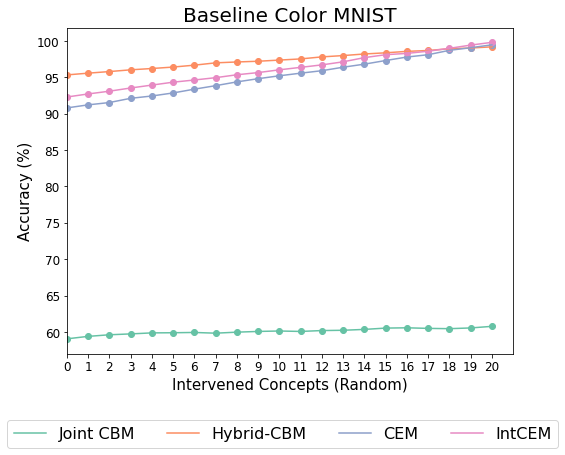

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
n_concepts = 20
xticks = list(range(0, n_concepts + 1))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    # "Mixing-CEM",
    # "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (Baseline)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    label = rename_map.get(label, label)
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Baseline Color MNIST", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

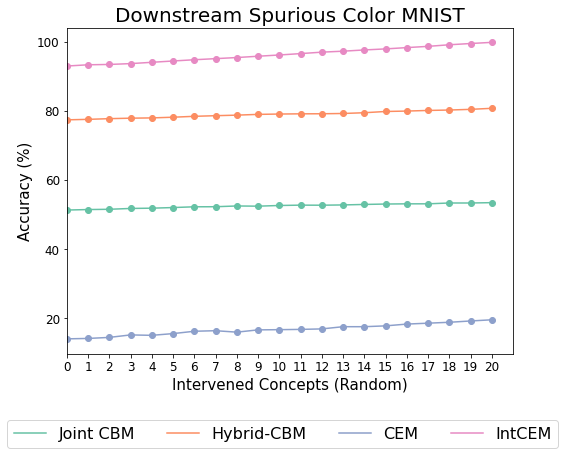

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    # "Mixing-CEM",
    # "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (Downstream Spurious)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    label = rename_map.get(label, label)
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Downstream Spurious Color MNIST", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

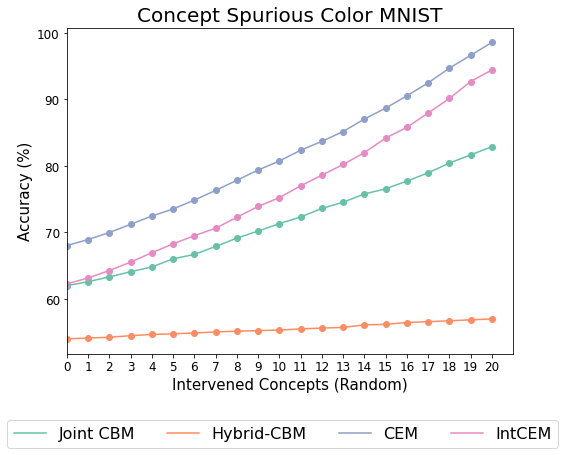

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    # "Mixing-CEM",
    # "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (Concept Spurious)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    label = rename_map.get(label, label)
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Concept Spurious Color MNIST", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

/home/me466/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/me466/venv/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/me466/venv/lib/python3.8/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/me466/venv/lib/python3.8/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/me466/venv/lib/python3.8/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must be the same size

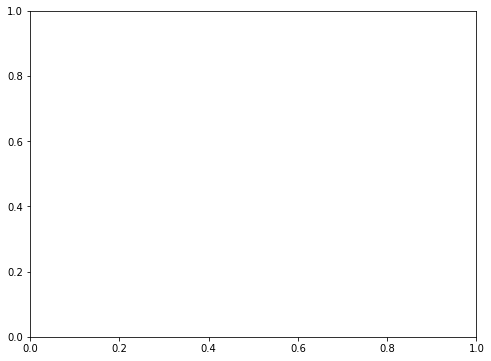

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    # "Sigmoidal CEM",
    "IntCEM",
    # "Mixing-CEM",
    # "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (OOD Baseline)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    label = rename_map.get(label, label)
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    ax.fill_between(
        xticks,
        means - stds,
        means + stds,
        alpha=0.2,
        facecolor=color,
    )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("OOD Color MNIST", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

#### All Modes Together

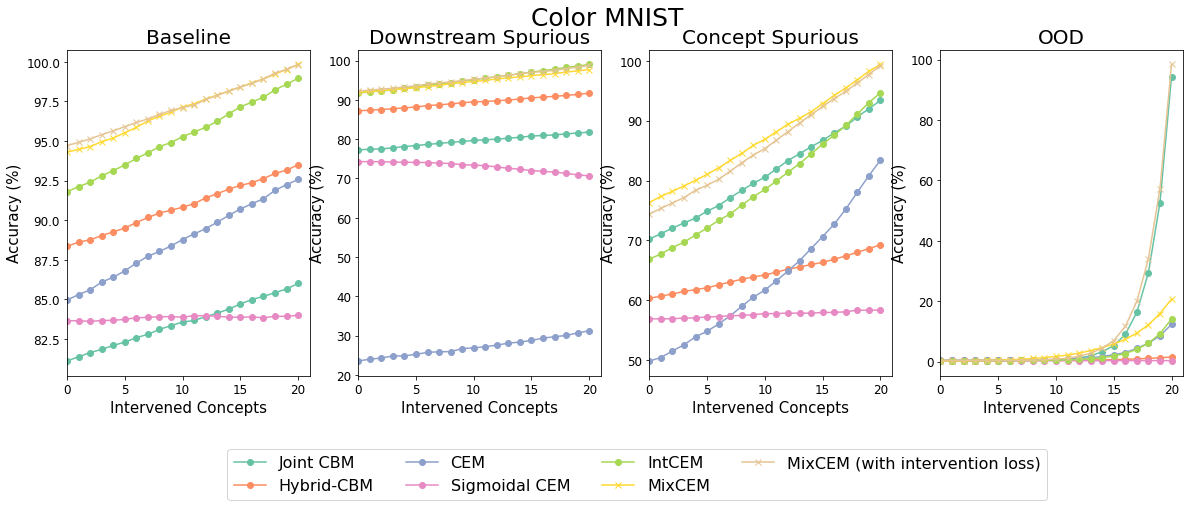

In [43]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, 21))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for ax, (mode_name, mode_key) in zip(
    axs,
    [
        ("Baseline", " (Baseline)"),
        ("Downstream Spurious", " (Downstream Spurious)"),
        ("Concept Spurious", " (Concept Spurious)"),
        ("OOD", " (OOD Baseline)"),
    ]
):
    for idx, label in enumerate([
        "Joint CBM",
        "Hybrid-CBM",
        "CEM",
        "Sigmoidal CEM",
        "IntCEM",
        "Mixing-CEM",
        "ResidualMixing-CEM",
        # "new_Mixing-CEM",
    ]):
        model_name = selected_models.get(
            label + mode_key,
            label,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            "test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = clrs[idx]
        ax.plot(
            means,
            "-x" if "MixCEM" in label else "-o",
            color=color,
            label=label,
        )
        # ax.scatter(
        #     xticks,
        #     means,
        #     color=color,
        #     marker="x" if "MixCEM" in label else ".",
        # )
        # ax.fill_between(
        #     xticks,
        #     means - stds,
        #     means + stds,
        #     alpha=0.2,
        #     facecolor=color,
        # )
    ax.set_xlim(0, len(means))
    # ax.set_xticks(xticks)
    ax.set_ylabel("Accuracy (%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(mode_name, fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
fig.suptitle("Color MNIST", fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=4,
)
plt.show()

# 75% Incomplete Color MNSIT Experiment

In [44]:
results_dir = '../results/color_mnist_add/incomplete_0.75/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))


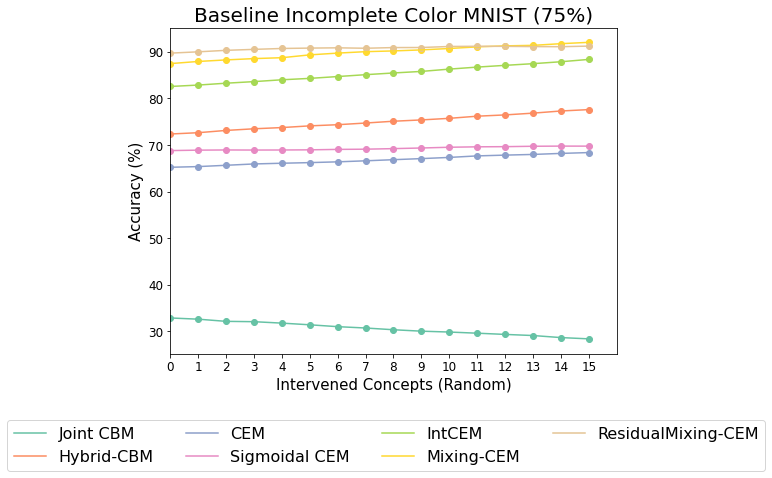

In [45]:
def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
n_concepts = 15
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models[label + " (Baseline)"]
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Baseline Incomplete Color MNIST (75%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10
Hybrid-CBM_Sigmoid_extra_dims_10_Noisy_Count_Downstream_Spurious_20_cwl_10
CEM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10
Sigmoid_CEM_Noisy_Count_Downstream_Spurious_20_cwl_10
IntCEM_intervention_weight_0.1_intervention_task_discount_1.5_Noisy_Count_Downstream_Spurious_20_cwl_10
Mixing-CEM_n_discovered_concepts_5_contr_loss_0_mix_True_shared_True_emb_size_256_Noisy_Count_Downstream_Spurious_20_cwl_10
ResidualMixing-CEM_n_extra_10_entr_0_dis_1.5_ip_[0.25, 0.5]_dip_0.1_cl_0_mix_True_shared_True_emb_size_256_ml_0_Noisy_Count_Downstream_Spurious_20_cwl_10


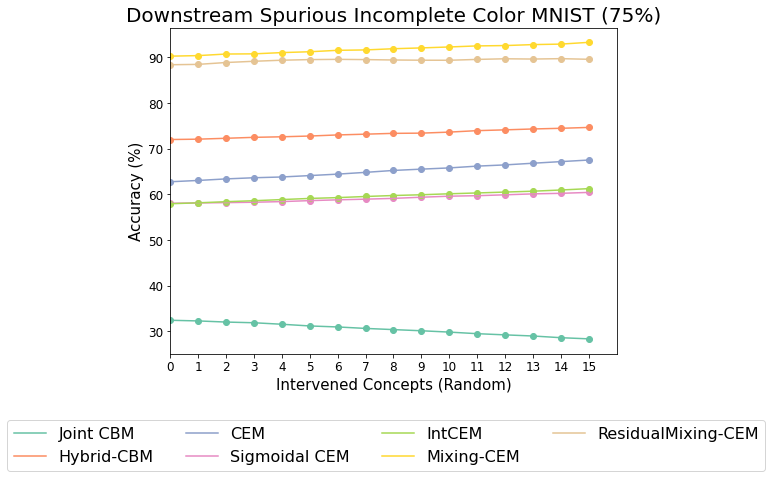

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (Downstream Spurious)",
        label,
    )
    print(model_name)
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Downstream Spurious Incomplete Color MNIST (75%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

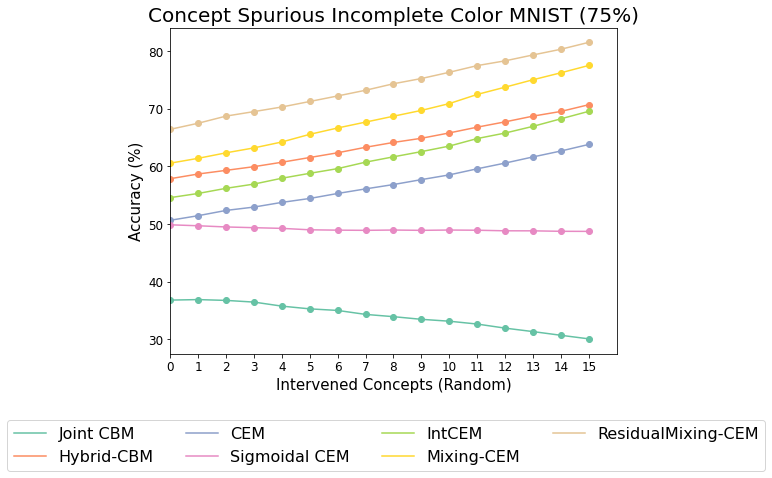

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models[label + " (Concept Spurious)"]
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Concept Spurious Incomplete Color MNIST (75%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

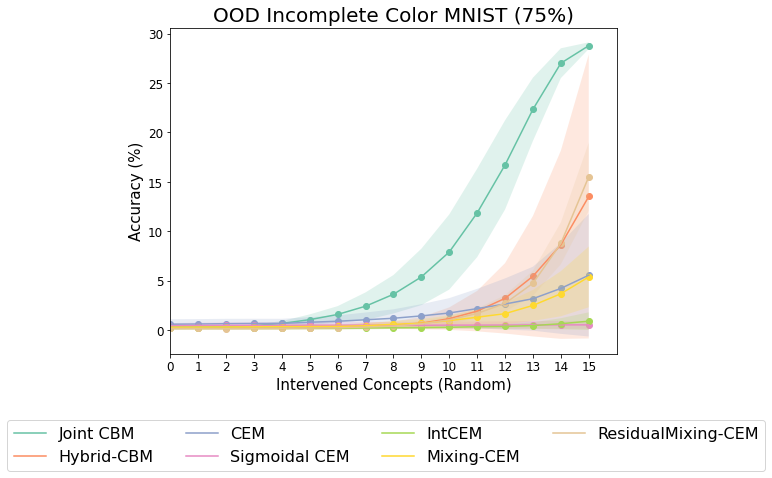

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "ResidualMixing-CEM",
    # "new_Mixing-CEM",
]):
    model_name = selected_models[label + " (OOD Baseline)"]
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    ax.fill_between(
        xticks,
        means - stds,
        means + stds,
        alpha=0.2,
        facecolor=color,
    )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("OOD Incomplete Color MNIST (75%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

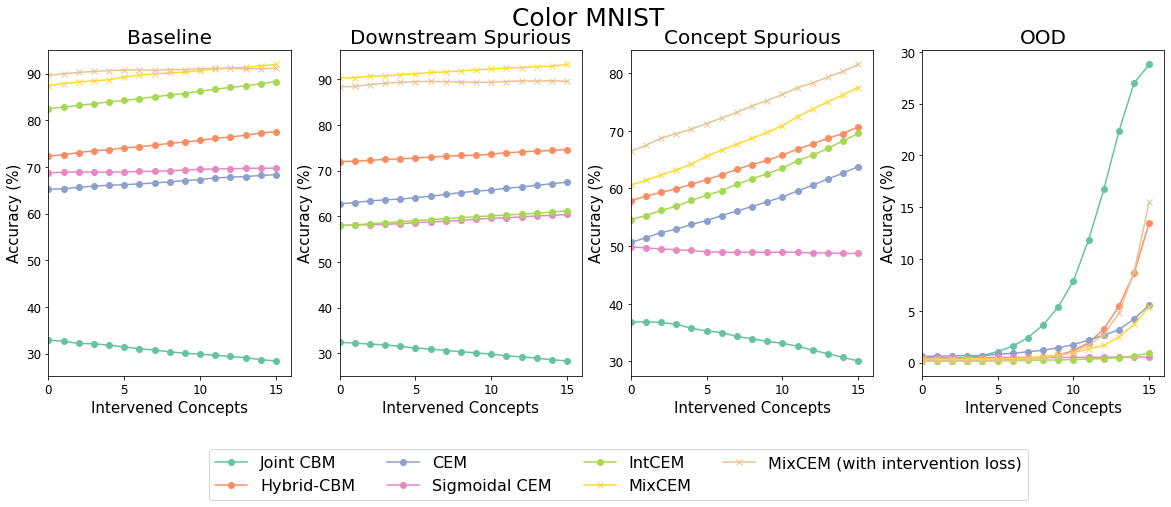

In [49]:
fig, axs = plt.subplots(1, 4, figsize=(20, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
rename_map = {
    "Mixing-CEM": "MixCEM",
    "ResidualMixing-CEM": "MixCEM (with intervention loss)",
}
for ax, (mode_name, mode_key) in zip(
    axs,
    [
        ("Baseline", " (Baseline)"),
        ("Downstream Spurious", " (Downstream Spurious)"),
        ("Concept Spurious", " (Concept Spurious)"),
        ("OOD", " (OOD Baseline)"),
    ]
):
    for idx, label in enumerate([
        "Joint CBM",
        "Hybrid-CBM",
        "CEM",
        "Sigmoidal CEM",
        "IntCEM",
        "Mixing-CEM",
        "ResidualMixing-CEM",
        # "new_Mixing-CEM",
    ]):
        model_name = selected_models.get(
            label + mode_key,
            label,
        )
        ints = np.array(get_metric_from_dict(
            results,
            model_name,
            "test_acc_y_random_group_level_True_use_prior_False_ints",
        ))
        label = rename_map.get(label, label)
        means = np.mean(ints, axis=0) * 100
        stds = np.std(ints, axis=0) * 100
        color = clrs[idx]
        ax.plot(
            means,
            "-x" if "MixCEM" in label else "-o",
            color=color,
            label=label,
        )
        # ax.scatter(
        #     xticks,
        #     means,
        #     color=color,
        #     marker="x" if "MixCEM" in label else ".",
        # )
        # ax.fill_between(
        #     xticks,
        #     means - stds,
        #     means + stds,
        #     alpha=0.2,
        #     facecolor=color,
        # )
    ax.set_xlim(0, len(means))
    # ax.set_xticks(xticks)
    ax.set_ylabel("Accuracy (%)", fontsize=15)
    ax.set_xlabel("Intervened Concepts", fontsize=15)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_title(mode_name, fontsize=20)
    handles, labels = ax.get_legend_handles_labels()
fig.suptitle("Color MNIST", fontsize=25)
ax.legend(
    handles,
    labels,
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(-1.25,-0.2),
    ncol=4,
)
plt.show()

# 50% Incomplete Color MNSIT Experiment

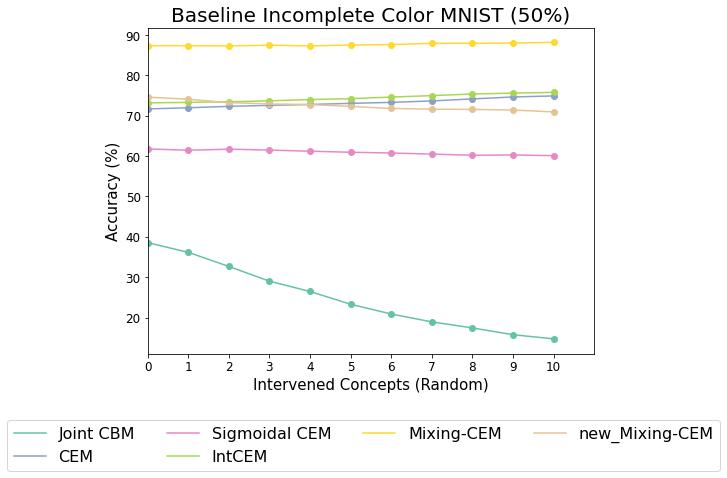

In [68]:
results_dir = '../results/color_mnist_add/incomplete/'
results = joblib.load(os.path.join(results_dir, 'results.joblib'))
selected_models = joblib.load(os.path.join(results_dir, 'selected_models_val_acc_y_random_group_level_True_use_prior_False_int_auc.joblib'))

def get_metric_from_dict(results, method, metric):
    vals = []
    for _, metric_keys in results.items():
        for candidate_method, metric_map in metric_keys.items():
            if method != candidate_method:
                continue
            for metric_name, val in metric_map.items():
                if metric_name == metric:
                    vals.append(val)
    return vals

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
n_concepts = 10
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (Baseline)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    if len(ints) == 0:
        continue
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Baseline Incomplete Color MNIST (50%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

CBM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_1
Hybrid-CBM
CEM_Sigmoid_Noisy_Count_Downstream_Spurious_20_cwl_10
Sigmoid_CEM_Noisy_Count_Downstream_Spurious_20_cwl_10
IntCEM_intervention_weight_1_intervention_task_discount_1.5_Noisy_Count_Downstream_Spurious_20_cwl_10
Mixing-CEM_n_discovered_concepts_5_contr_loss_0_mix_True_shared_True_emb_size_128_Noisy_Count_Downstream_Spurious_20_cwl_10
new_Mixing-CEM_n_discovered_concepts_5_contr_loss_0_mix_True_shared_True_emb_size_256_sp_False_cd_False_med_loss_0.1_p_0.25_Noisy_Count_Downstream_Spurious_20_cwl_10


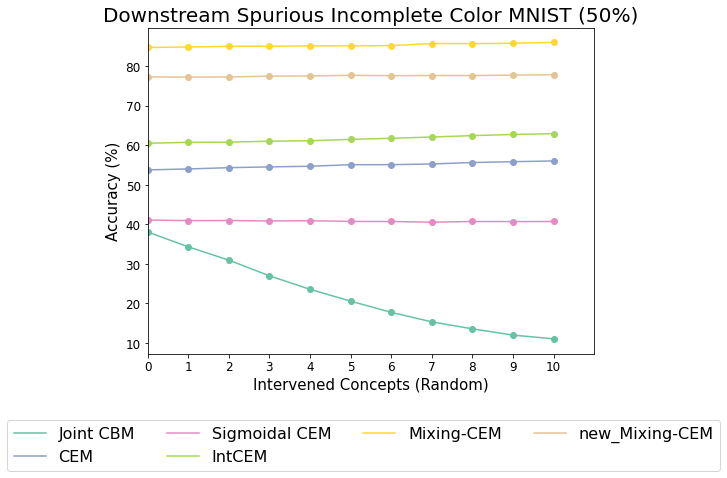

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "new_Mixing-CEM",

]):
    model_name = selected_models.get(
        label + " (Downstream Spurious)",
        label,
    )
    print(model_name)
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    if len(ints) == 0:
        continue
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Downstream Spurious Incomplete Color MNIST (50%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

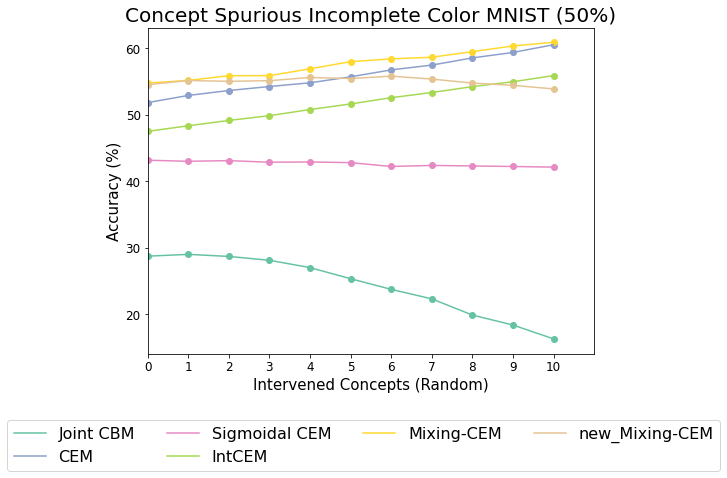

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (Concept Spurious)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    if len(ints) == 0:
        continue
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    # ax.fill_between(
    #     xticks,
    #     means - stds,
    #     means + stds,
    #     alpha=0.2,
    #     facecolor=color,
    # )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("Concept Spurious Incomplete Color MNIST (50%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()

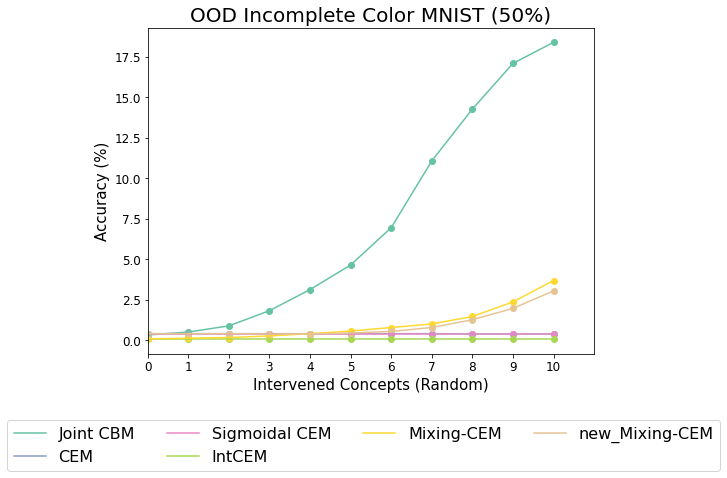

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
clrs = sns.color_palette("Set2", 20)
xticks = list(range(0, n_concepts + 1))
for idx, label in enumerate([
    "Joint CBM",
    "Hybrid-CBM",
    "CEM",
    "Sigmoidal CEM",
    "IntCEM",
    "Mixing-CEM",
    "new_Mixing-CEM",
]):
    model_name = selected_models.get(
        label + " (OOD Baseline)",
        label,
    )
    ints = np.array(get_metric_from_dict(
        results,
        model_name,
        "test_acc_y_random_group_level_True_use_prior_False_ints",
    ))
    if len(ints) == 0:
        continue
    means = np.mean(ints, axis=0) * 100
    stds = np.std(ints, axis=0) * 100
    color = clrs[idx]
    ax.scatter(
        xticks,
        means,
        color=color,
    )
    ax.plot(
        means,
        color=color,
        label=label,
    )
    ax.fill_between(
        xticks,
        means - stds,
        means + stds,
        alpha=0.2,
        facecolor=color,
    )
ax.set_xlim(0, len(means))
ax.set_xticks(xticks)
ax.set_ylabel("Accuracy (%)", fontsize=15)
ax.set_xlabel("Intervened Concepts (Random)", fontsize=15)
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_title("OOD Incomplete Color MNIST (50%)", fontsize=20)
lgd = fig.legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5,-0.01),
    ncol=4,
)
plt.show()